# <center>TPS Integration </center>

### PortPy can generate DICOM RT plan for PortPy plans that can can be imported to Treatment Planning System (TPS). This compatibility enables users to import the PortPy plan into the FDA-approved TPS system for a final clinical evaluation. This example outlines the following steps:


1. Creating a simple IMRT plan (Plan class, Optimization class)

2. Perform leaf sequencing in Portpy for IMRT plan and generate dicom RT plan file which can be imported to FDA approved TPS (Utils class)

3. Importing the PortPy plan into the TPS system for final dose calculation

4. Exporting the finally calculated dose from the TPS (Eclipse) system (in DICOM RT-Dose format) into PortPy (Utils class)

5. Comparing the PortPy plan against the TPS plan for validation and analysis 


In [1]:
import sys
sys.path.append('..')

In [2]:
import portpy.photon as pp
import os
import matplotlib.pyplot as plt
import cvxpy as cp

### 1) Creating a simple IMRT plan (Plan class, Optimization class)


In [3]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# Pick a patient 
data.patient_id = 'Lung_Patient_6'
# Load ct, structure set, beams for the above patient using CT, Structures, and Beams classes
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
# Pick a protocol
protocol_name = 'Lung_2Gy_30Fx'
# Load clinical criteria for a specified protocol
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# Load hyper-parameter values for optimization problem for a specified protocol
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Create optimization structures (i.e., Rinds) 
structs.create_opt_structures(opt_params=opt_params, clinical_criteria=clinical_criteria)
# Load influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# Create a plan using ct, structures, beams and influence matrix, and clinical criteria
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria)

# Create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params, clinical_criteria=clinical_criteria)
opt.create_cvxpy_problem()
# Solve the cvxpy problem using Mosek
sol = opt.solve(solver='MOSEK', verbose=False)

creating rinds.. This step may take some time due to dilation
Optimization structures created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 44.28361511875611
Elapsed time: 87.32421255111694 seconds


### 2) Perform leaf sequencing in Portpy for IMRT plan and generate dicom RT plan file (Utils class)
The method *leaf_sequencing_siochi* perform leaf sequencing for the PortPy plan and return dictionary containg leaf position for each beam angle. Please follow these steps to proceed:

1. Perform leaf sequencing for the PortPy generated Plan

2. Create dicom RT Plan file which can be imported in FDA-aprooved TPS

3. Import the patient's data into the TPS system. This includes CT images and RT structures that are not included in the PortPy dataset and need to be downloaded from the [TCIA website](https://www.cancerimagingarchive.net/access-data/). The user can obtain the *TCIA collection ID* and *TCIA subject ID* using *get_tcia_metadata()* method in PortPy. Along with the above patient's data, import RT plan dicom to TPS 

4. Finally, in TPS, execute final dose calculation.


In [6]:
# Perform leaf sequencing for the PortPy generated Plan. PortPy currently performs leaf sequencing based upon intensity modulated beams with multiple static segments according to
# Siochi (1999) International Journal of Radiation Oncology * Biology * Physics

leaf_sequencing = pp.leaf_sequencing_siochi(my_plan, sol)

In [ ]:
# create dicom RT Plan file to be imported in TPS
out_rt_plan_file = r'C:\Temp\PortPy\data\Lung_Patient_6\rt_plan_portpy_imrt.dcm' # change this file directory based upon your needs
in_rt_plan_file = r'C:\Temp\PortPy\data\Lung_Patient_6\rt_plan_echo_imrt.dcm' # change this directory as per your directory
pp.write_rt_plan_imrt(my_plan, leaf_sequencing, out_rt_plan_file, in_rt_plan_file)

In [7]:
# get the corresponding tcia collection/subject ID
data.get_tcia_metadata()

{'portpy_patient_id': 'Lung_Patient_6', 'subject_id': 'LUNG1-007', 'collection_id': 'NSCLC-Radiomics'}


### 3) Exporting the finally calculated dose from the TPS system into PortPy
After the final dose calculation in Eclipse, export the dose in DICOM RT-Dose format using the Eclipse Export module. Then, utilize the following lines of code to convert the exported dose into the PortPy format for visualization or evaluation purposes

In [8]:
# Specify the location and name of the DICOM RT Dose file
dose_file_name = os.path.join(r'C:\temp', data.patient_id, 'rt_dose_portpy_imrt.dcm')  
# Convert the DICOM dose into PortPy format
ecl_dose_3d = pp.convert_dose_rt_dicom_to_portpy(my_plan=my_plan, dose_file_name=dose_file_name)
ecl_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=ecl_dose_3d)

### 4)  Comparing the PortPy plan against the TPS plan for validation and analysis 

Finally dose exported from TPS in RT-dose DICOM file can be compared against PortPy dose using full influence matrix


Creating BEV..
Loading full influence matrix..
Done


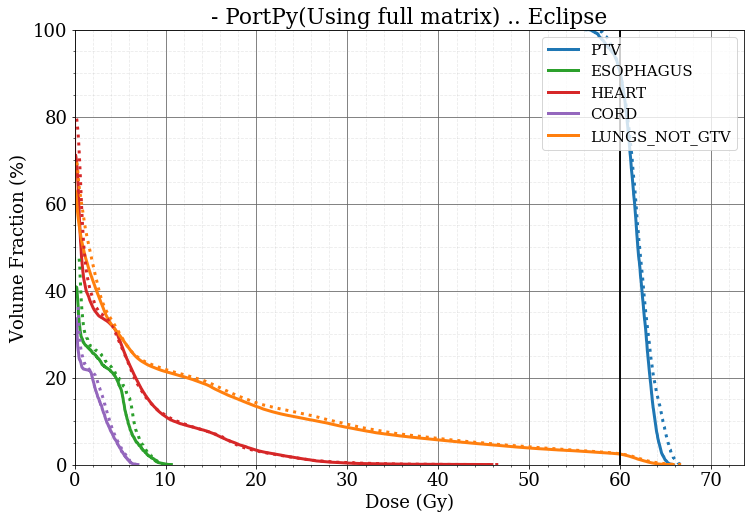

In [10]:
beams_full = pp.Beams(data, load_inf_matrix_full=True)
# load influence matrix based upon beams and structure set
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
dose_full_1d = inf_matrix_full.A @ (leaf_sequencing['optimal_intensity'] * my_plan.get_num_of_fractions())  # calculate dose using full matrix

# Visualize the DVH discrepancy between eclipse dose and dose using full matrix in portpy
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNGS_NOT_GTV']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_full_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- PortPy(Using full matrix) .. Eclipse')
plt.show()